In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay

df = pd.read_csv('S05-hw-dataset.csv', sep=',', encoding='cp1251', skipinitialspace=True, decimal=',')
print(df.head())
print("++++++++++INFO++++++++++")
print(df.info())
print("++++++++++DESCRIBE++++++++++")
print(df.describe())
print("++++++++++TARGET DESTR++++++++++")
print(df['default'].value_counts(normalize=True))
print("++++++++++NULL++++++++++")
print(df.isna().mean())
print("++++++++++DUPLICATES++++++++++")
print(df[df.duplicated()])

   client_id  age  income  years_employed  credit_score       debt_to_income  \
0          1   25   94074              22           839   0.5473390103151166   
1          2   58   51884              26           565  0.29088249926636534   
2          3   53   48656              39           561   0.5223400611426802   
3          4   42   81492              30           582    0.709122740102668   
4          5   42   94713               8           642   0.7933920649976469   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance    region_risk_score  \
0            26057              5229 

In [33]:
y = df['default']
X = df.drop(columns=['default', 'client_id'])
X = X.select_dtypes(include='number')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)
y_test_pred_baseline = baseline.predict(X_test)
y_test_proba_baseline = baseline.predict_proba(X_test)[:, 1]
dum_ac = accuracy_score(y_test, y_test_pred_baseline)
print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_baseline))
print("Precision:", precision_score(y_test, y_test_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_baseline, zero_division=0))
try:
    print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_baseline))
    dum_roc = roc_auc_score(y_test, y_test_proba_baseline)
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.59
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


Бейзлайн — это простейшая модель, которая не учится из признаков, а использует тривиальную стратегию (например, всегда предсказывает наиболее частый класс).

Accuracy показывает, насколько часто модель права, но может вводить в заблуждение при дисбалансе классов.
ROC-AUC оценивает способность модели ранжировать объекты (разделять классы), и для бейзлайна она равна 0.5, что соответствует случайному предсказанию.

Наличие бейзлайна даёт точку отсчёта: любая «настоящая» модель должна значительно превосходить этот уровень, иначе она бесполезна.

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print("Accuracy на тесте: ", round(accuracy, 4))
print("ROC-AUC на тесте:  ", round(roc_auc, 4))

Accuracy на тесте:  0.6833
ROC-AUC на тесте:   0.7336


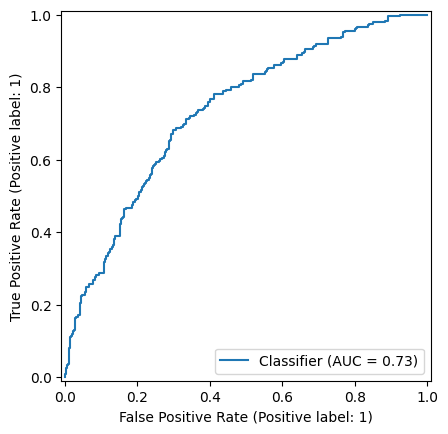

In [35]:
RocCurveDisplay.from_predictions(
    y_test,
    y_proba,
)
plt.savefig('figures/roc.png', bbox_inches='tight')

In [38]:
summary_df = pd.DataFrame({
    "Модель": ["DummyClassifier (бейзлайн)", "LogisticRegression"],
    "Accuracy": [dum_ac, accuracy],
    "ROC-AUC": [dum_roc, roc_auc]
})
print(summary_df)
summary_df.to_csv("artifacts/model.csv", index=False)

                       Модель  Accuracy   ROC-AUC
0  DummyClassifier (бейзлайн)  0.590000  0.500000
1          LogisticRegression  0.683333  0.733556


Бейзлайн просто угадывает самый частый класс (ROC-AUC = 0.50, Accuracy = 0.59), не используя признаки. Логистическая регрессия значительно лучше: Accuracy выросла до 0.68, ROC-AUC — до 0.73.
При подборе C лучшее качество дало значение C = 1.0: слабая регуляризация (C большое) не помогала, сильная (C маленькое) ухудшала результат.
Вывод: логистическая регрессия — разумный выбор: она проста, интерпретируема и явно полезна, в отличие от бейзлайна.